## Definitions

In [ ]:
# writing into excel library - uncomment the following line if needed
#!pip install openpyxl

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from main import simulate_apartment_stock, generate_interventions, simulate_social_housing, calculate_costs
from analysis import * 
import copy

idx = pd.IndexSlice

# Model systému podpory v bydlení
- [Ospravedlnění parametrů zde](https://mmrcz.sharepoint.com/:x:/r/sites/MMR-Zkonopodpoevbydlen/_layouts/15/guestaccess.aspx?share=EUy9k9Fw9JRLulyihYTMte8BSMkRlmAFsrVMBXySWvKGGg)

## Nabídka - byty v systému

* Nabídka simuluje počet bytů v systému, které budou k dispozici pro domácnosti v bytové nouzi. Model simuluje zvlášť byty ze soukromého sektoru a byty, které jsou ve správě místních samospráv
* Nastavení modelu vede k  (téměř) lineárnímu vkladu bytů do systému. Defaultní nastavení vede k tempu 5000 soukromých a pomalu rostoucích cca 3500 - 4000 městských bytů v systému ročně.

### Garantované byty
* Nabídka garantovaných bytů závisí primárně na konkurenceschopnosti podmínek pro pronajímatale a úspěšnosti komunikace
* Jejich počet proto je modelován jediným parametrem: `guaranteed_yearly_apartments`.
* Z komunikace s Romanem Matouškem proto vzešel návrh zvažovat tři scénáře: 
    - *Konzervativní* - 2 500 bytů ročně, tj. 10 bytů na ORP, tedy méně než 1 byt na ORP za měsíc
    - *Střední* - 5 000 bytů ročně
    - *Rozsáhlý* - 10 000 bytů ročně
* Pokud není řečeno jinak je použit *střední scénář* 

### Obecní byty
* Již dnes existuje cca 200 000 bytů - `municipal_apartments_today`
* Z již existujících bytů se každoročně 1,5 % uvolní do systému sociálního bydlení - `municipal_existing_availability_rate`
* I v budoucnu budou stavět nové městské byty - konzervativně předpokládáme 1000 bytů ročně - `municipal_yearly_new_apartments`
* Z nových bytů předpokládáme, že by do systému výrazně větší část - klidně 50 % - `municipal_new_availability_rate`

## Poptávka - rozsah bytové nouze

* Také poptávka je modelována 2 druhy domácností
* Model prefenčně umísťuje *méně rizikové* domácnosti do *garantovaných* bytů a *rizikové* domácnosti do *obecních* bytů 
* Oba druhy domácností mají v čase lineární trend

* Celkově je 50 000 domácností v bytové nouzi - z toho 65 % domácností jsou  *méně rizikové* domácnosti a  35 % *rizikové* domácnosti
* Předpokládáme každoroční přísun dalších 5 000 domácností - z toho 65 % domácností jsou  *méně rizikové* domácnosti a  35 % *rizikové* domácnosti

### 2 varianty poptávky 
#### optimistický výhled

In [2]:
current_level = 50000
yearly_growth_optimistic = 3000

high_current = .7
high_yearly = .35

hhs_inflow_optimistic = pd.Series({
    ('low','current_level'): (1 - high_current) * current_level,
    ('low','yearly_growth'): (1 - high_yearly) * yearly_growth_optimistic,
    ('high','current_level'): high_current * current_level,
    ('high','yearly_growth'): high_yearly * yearly_growth_optimistic,
}).unstack()
hhs_inflow_optimistic

,current_level,yearly_growth
high,35000.0,1050.0
low,15000.0,1950.0


#### Pesimistický výhled

In [3]:
yearly_growth_pesimistic = 6000

hhs_inflow_pesimistic = pd.Series({
    ('low','current_level'): (1 - high_current) * current_level,
    ('low','yearly_growth'): (1 - high_yearly) * yearly_growth_pesimistic,
    ('high','current_level'): high_current * current_level,
    ('high','yearly_growth'): high_yearly * yearly_growth_pesimistic,
}).unstack()
hhs_inflow_pesimistic

,current_level,yearly_growth
high,35000.0,2100.0
low,15000.0,3900.0


## Intervence a průchod domácnosti systémem
### "Měkké" intervence
* Pokud se domácnost dostane do BN, zařazuje se do tzv. fronty (`queue`).
* Domácnosti ve frontě postupně dostávají intervence:
    1. `self-help` - některé domácnosti si zvládnou pomoci samy a dostanou se ven z BN
    2. `consulting` - další část domácností přijde pro poradenství na KMB a díky tomu se zvládnou dostat ven z BN
    3. `mop_payment` - další část domácností po konzultaci na KMB dostane vyplacenou dávku MOP
* V následující tabulce je uveden podíl domácností ve froně, kterým se dostane této podpory
* Je třeba si uvědomit, že uvedené podíly se aplikují postupně a tedy postupně ubývá základ vůči kterému se podíly aplikují

In [4]:
intervention_shares_v0 = pd.Series({
    ('low','self_help'):.4, #
    ('low','consulting'):.0,
    ('low','mop_payment'):.02,
    ('high','self_help'):.15,
    ('high','consulting'):.0,
    ('high','mop_payment'):.02
}).unstack()
intervention_shares_v0

,consulting,mop_payment,self_help
high,0.0,0.02,0.15
low,0.0,0.02,0.40


In [5]:
intervention_shares_v1 = pd.Series({
    ('low','self_help'):.2,
    ('low','consulting'):.1,
    ('low','mop_payment'):.2,
    ('high','self_help'):.1,
    ('high','consulting'):.05,
    ('high','mop_payment'):.1
}).unstack()
intervention_shares_v1

,consulting,mop_payment,self_help
high,0.05,0.1,0.1
low,0.10,0.2,0.2


### Umístění do bytů
* Domácnosti, které nezískají žádnou z "měkkých" intervencí se pokusíme umístit do bytů
* Také zde probíhá konzultace s KMB - je třeba počítat s náklady
* Po umístění do bytů probíhá sociální práce - Asistence v bydlení - je třeba počítat s náklady
* Umístění do bytů probíhá dvou-fázově: 
    1. Primární umístění:
        a. Méně rizikové domácnosti -> garantované bydlení
        b. Rizikové domácnosti -> obecní byty
    2. Sekundární umístění:
        a. Rizikové domácnosti -> garantované bydlení
        b. Méně rizikové domácnosti -> obecní byty
* Vždy jsou umístěny všechny domácnosti do všech aktuálně dostupných bytů

### Délka intervence

* Každá intervence má jinou dobu trvání
* Zatímco měkké intervence jsou jednorázové a z pohledu modelu trvají jeden rok, bydlení trvá déle

In [6]:
years_of_support = pd.Series({
    'municipal':3, # or 5 years
    'guaranteed':2,
    'self_help':1,
    'mop_payment':1,
    'consulting':1
})
years_of_support

municipal      3
guaranteed     2
self_help      1
mop_payment    1
consulting     1
dtype: int64

### Relaps - neúspěšné intervence

* část domácností, se i přes to, že dostanou intervenci, se po čase zase vrátí do problémů
* Tomu model říká "relaps" - po konci intervenci domácnost neopouští systém, ale vrací se zpátky do fronty
* Tabulka níže ukazuje, jaká část domácností, které dostaly danou intervenci se po konci intervence vrací zpět do systému

In [7]:
relapse_rates = pd.Series({
    ('low','self_help'):.2,
    ('low','consulting'):.2,
    ('low','mop_payment'):.1,
    ('low','guaranteed'):.05,
    ('low','municipal'):.05,
    ('high','self_help'):.6,
    ('high','consulting'):.5,
    ('high','mop_payment'):.3,
    ('high','guaranteed'):.3,
    ('high','municipal'):.3
}).unstack()

relapse_rates

,consulting,guaranteed,mop_payment,municipal,self_help
high,0.5,0.30,0.3,0.30,0.6
low,0.2,0.05,0.1,0.05,0.2


### Použití sociální asistence

* Podíl intervenovaných, kteří zároveň s intervencí dostanou sociální asistenci a délku jejího trvání

In [8]:
social_assistences_v0 = pd.Series({
    ('mop_payment','share'): .0,
    ('mop_payment','years'): 1,
    ('guaranteed','share'): .0,
    ('guaranteed','years'): 2,
    ('municipal','share'): .85,
    ('municipal','years'): 2,
}).unstack()

social_assistences_v0

,share,years
guaranteed,0.00,2.0
mop_payment,0.00,1.0
municipal,0.85,2.0


In [9]:
social_assistences_v1 = pd.Series({
    ('mop_payment','share'): .5,
    ('mop_payment','years'): 1,
    ('guaranteed','share'): .85,
    ('guaranteed','years'): 2,
    ('municipal','share'): .85,
    ('municipal','years'): 2,
}).unstack()

social_assistences_v1

,share,years
guaranteed,0.85,2.0
mop_payment,0.50,1.0
municipal,0.85,2.0


### Náklady intervencí

* Rozlišujeme tři druhy nákladů:
    * **Fixní** - náklady existence systému sociálního bydlení, zcela nezávislé na výkonu - např. IT systém. V modelu nejsou žádným způsobem zohledněny.
    * **Vstupní** - náklady provedení intervence - například sehnání bytu do systému či vyplacení MOP
    * **Průběžné/Roční** - náklady existující intervence - náklady bytu


In [10]:
intervention_costs = pd.Series({
    ('entry','self_help'):0,
    ('entry','consulting'):11000,
    ('entry','mop_payment'):38200,
    ('entry','guaranteed'):25200,
    ('entry','municipal'):13200,
    ('entry', 'social_assistance'): 0,
    ('yearly','self_help'):0,
    ('yearly','consulting'):0,
    ('yearly','mop_payment'):0,
    ('yearly','guaranteed'):25000,
    ('yearly','municipal'):25000,
    ('yearly','social_assistance'): 75000,
    ('yearly','queue_budget'): 50234, # https://drive.google.com/drive/u/0/folders/1AB-eICOTy3LndCi75t68i2aCKKgxXlrd p.47
    ('yearly','queue_social'): 172942 # https://drive.google.com/drive/u/0/folders/1AB-eICOTy3LndCi75t68i2aCKKgxXlrd p.47
}).unstack()
intervention_costs

,consulting,guaranteed,mop_payment,municipal,queue_budget,queue_social,self_help,social_assistance
entry,11000.0,25200.0,38200.0,13200.0,NaN,NaN,0.0,0.0
yearly,0.0,25000.0,0.0,25000.0,50234.0,172942.0,0.0,75000.0


## Specifikace variant

In [11]:
VARIANT_0_OPTIMISTIC = {
    'title': 'Varianta 0 - Optimistická',
    'years':np.arange(20),
    'years_of_support':years_of_support,
    'intervention_costs':intervention_costs,
    'guaranteed_yearly_apartments':0, # Konzervativní odhad 2500 - 1 byt na měsíc pro každé ORP; Divoký odhad 10 000 bytl,
    'municipal_apartments_today': 175000,
    'municipal_yearly_new_apartments': 300, # upper estimate 1000
    'municipal_existing_availability_rate': .01,
    'municipal_new_availability_rate': .01, # liší se ve v1
    'relapse_rates':relapse_rates,
    'intervention_shares':intervention_shares_v0,
    'hhs_inflow':hhs_inflow_optimistic,
    'social_assistences':social_assistences_v0
}

VARIANT_0_PESIMISTIC = copy.deepcopy(VARIANT_0_OPTIMISTIC)
VARIANT_0_PESIMISTIC['title'] = 'Varianta 0 - Pesimistická'
VARIANT_0_PESIMISTIC['hhs_inflow'] = hhs_inflow_pesimistic

In [12]:
VARIANT_1_OPTIMISTIC = {
    'title': 'Varianta 1 - Optimistická',
    'years':np.arange(20),
    'years_of_support':years_of_support,
    'intervention_costs':intervention_costs,
    'guaranteed_yearly_apartments':2000, # Upper estimate 5000
    'municipal_apartments_today': 175000,
    'municipal_yearly_new_apartments': 300, # upper estimate 1000
    'municipal_existing_availability_rate': .01,
    'municipal_new_availability_rate': .25,# liší se ve v0
    'relapse_rates':relapse_rates,
    'intervention_shares':intervention_shares_v1,
    'hhs_inflow':hhs_inflow_optimistic,
    'social_assistences':social_assistences_v1
}

VARIANT_1_PESIMISTIC = copy.deepcopy(VARIANT_1_OPTIMISTIC)
VARIANT_1_PESIMISTIC['title'] = 'Varianta 1 - Pesimistická'
VARIANT_1_PESIMISTIC['hhs_inflow'] = hhs_inflow_pesimistic

## Hlavní výsledky

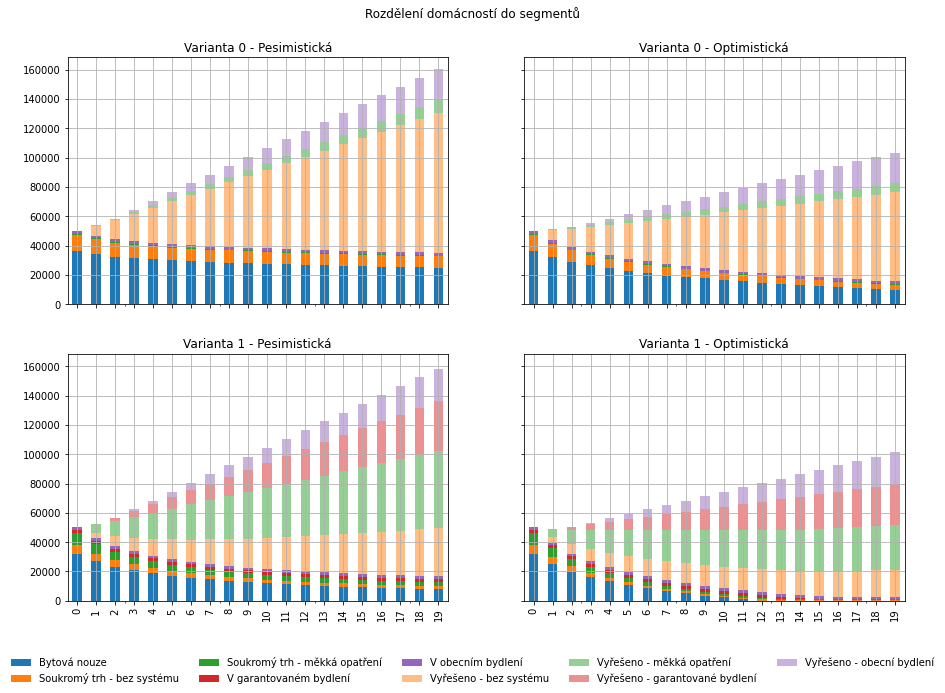

In [13]:
plot_4_variants(
    variant_1A=VARIANT_0_PESIMISTIC, 
    variant_1B=VARIANT_1_PESIMISTIC, 
    variant_2A=VARIANT_0_OPTIMISTIC, 
    variant_2B=VARIANT_1_OPTIMISTIC, 
    plot_function = 'plot_hhs'
);

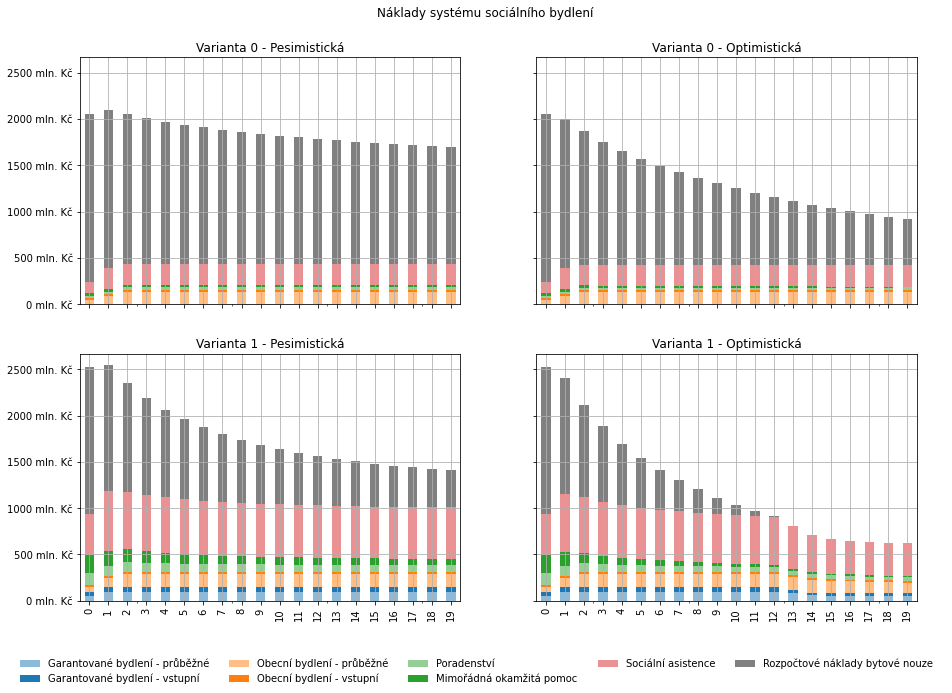

In [14]:
plot_4_variants(
    variant_1A=VARIANT_0_PESIMISTIC, 
    variant_1B=VARIANT_1_PESIMISTIC, 
    variant_2A=VARIANT_0_OPTIMISTIC, 
    variant_2B=VARIANT_1_OPTIMISTIC, 
    plot_function = 'plot_costs'
);

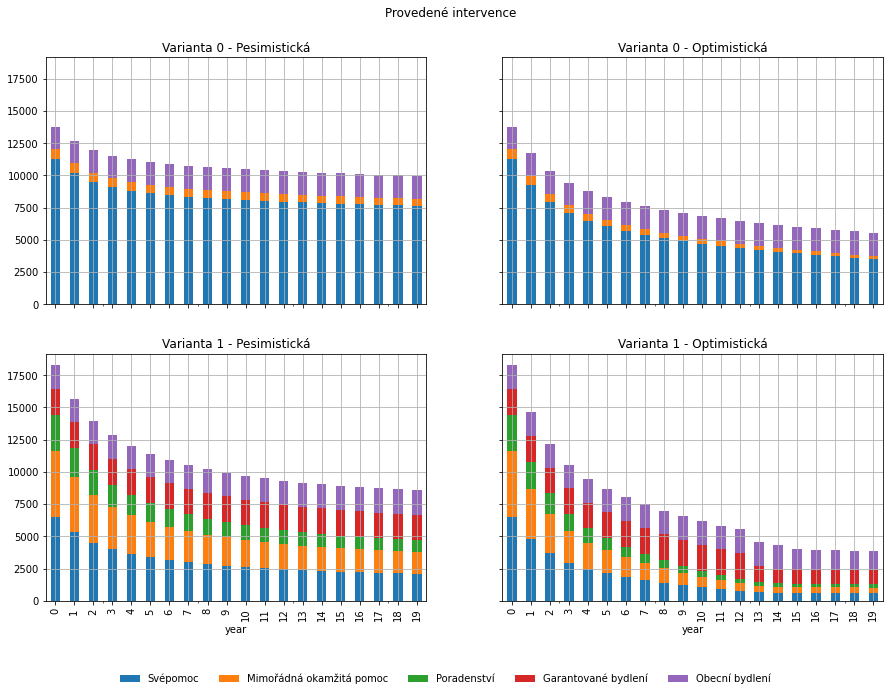

In [15]:
plot_4_variants(
    variant_1A=VARIANT_0_PESIMISTIC, 
    variant_1B=VARIANT_1_PESIMISTIC, 
    variant_2A=VARIANT_0_OPTIMISTIC, 
    variant_2B=VARIANT_1_OPTIMISTIC, 
    plot_function = 'plot_interventions'
);

### Pro podrobnější zkoumání lze exportovat data z jednotlivých simulací do XLSX

In [ ]:
save_tables_to_excel(
    [VARIANT_0_PESIMISTIC, VARIANT_1_PESIMISTIC, VARIANT_0_OPTIMISTIC, VARIANT_1_OPTIMISTIC],
    'hlavni_varianty.xlsx'
)

## Detailní pohed na 2 varianty

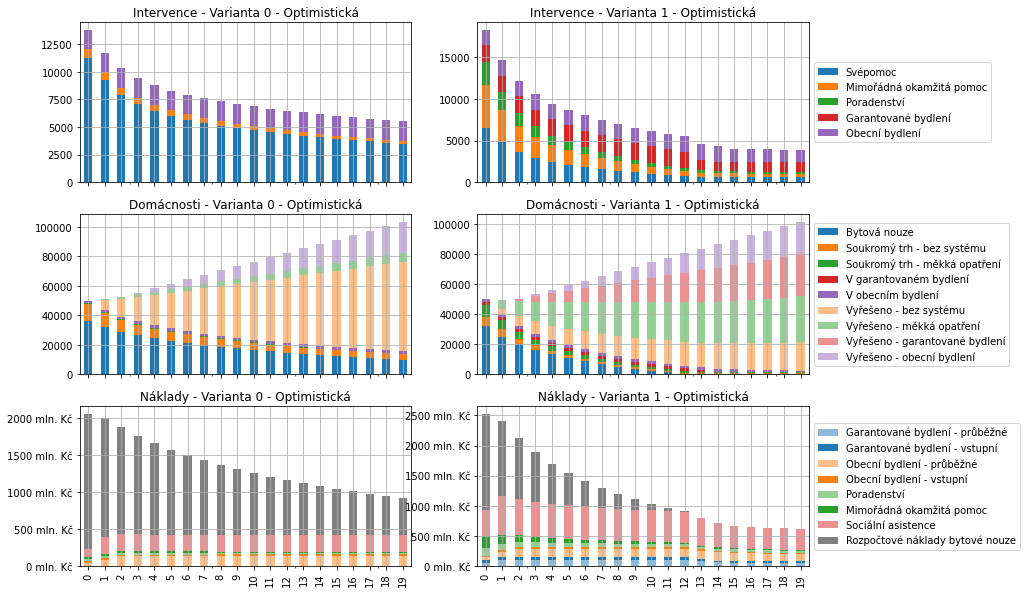

In [16]:
compare_variants(VARIANT_0_OPTIMISTIC, VARIANT_1_OPTIMISTIC);

## Příklad: Častější MOPky

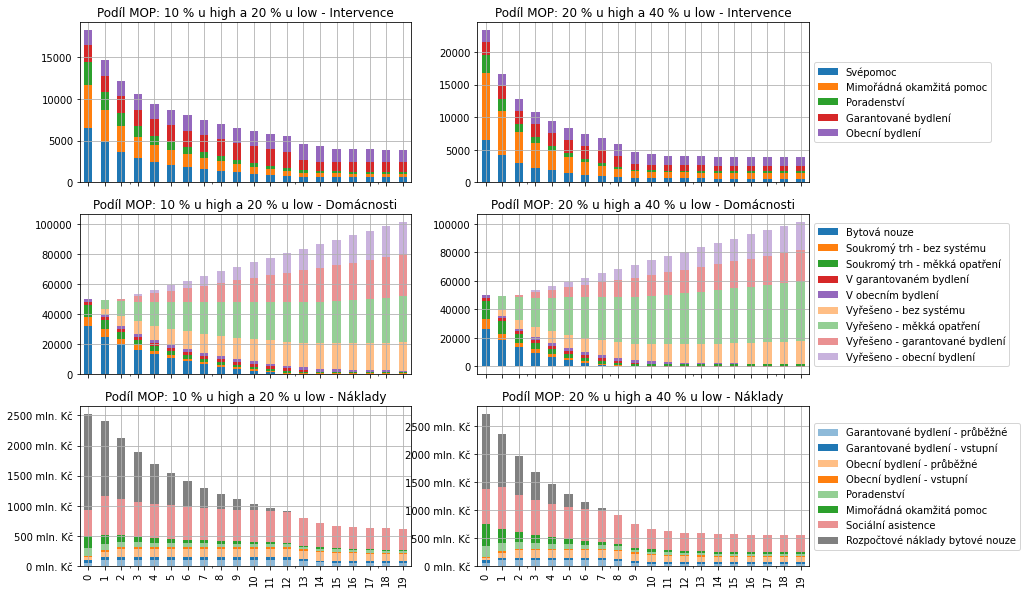

In [18]:
default_variant = copy.deepcopy(VARIANT_1_OPTIMISTIC)
default_variant['title'] = 'Podíl MOP: 10 % u high a 20 % u low'

variant_more_mops = copy.deepcopy(default_variant)
variant_more_mops['intervention_shares'].loc['high','mop_payment'] = variant_more_mops['intervention_shares'].loc['high','mop_payment'] * 2
variant_more_mops['intervention_shares'].loc['low','mop_payment'] = variant_more_mops['intervention_shares'].loc['low','mop_payment'] * 2
variant_more_mops['title'] = 'Podíl MOP: 20 % u high a 40 % u low'

compare_variants(default_variant, variant_more_mops);